# Ch 8 - I/O

input/output is an important component of the von Neumann model. 

There must be a way to get information into the computer in order to process it, and there must be a way to get the result of that processing out of the computer so humans can use it.

**I/O can be accomplished by executing the `TRAP` instruction, which asks the OS to do it for us**

We're now ready to do I/O by ourselves. We have chosen to study the keyboard as our input device and the monitor display as our output device. 
- Not only are they the simplest I/O devices and the ones most familiar to us, but they have characteristics that allow us to study important concepts about I/O without getting bogged down in unnecessary detail.

## 8.1 I/O Basics
### 8.1.1 Device Registers
Although we often think of an I/O device as a single entity, **interaction with a single I/O device usually means interacting with more than one device register**. 

The simplest I/O devices usually have at least two device registers: 
1. one to hold the data being transferred between the device and the computer
2. one to indicate status information about the device.

- An example of status information is whether the device is available or is still busy processing the most recent I/O task.

### 8.1.2 Memory-Mapped I/O versus Special Input/Output Instructions 
An instruction that interacts with an input or output device register must identify the particular input or output device register with which it is interacting. 

Two schemes have been used in the past. 
- Some computers use special input and output instructions. 
- Most computers prefer to use the same data movement instructions that are used to move data in and out of memory.

The very old PDP-8 (from Digital Equipment Corporation, light years ago— 1965) is an example of a computer that used special input and output instructions. The 12-bit PDP-8 instruction contained a 3-bit opcode. If the opcode was 110, an I/O instruction was indicated.
The remaining nine bits of the PDP-8 instruction identified which I/O device register and what operation was to be performed. 

Most computer designers prefer not to specify an additional set of instructions
for dealing with input and output. They use the same data movement instructions
that are used for loading and storing data between memory and the general purpose
registers.

**Eg:** 
- a load instruction, in which the source address is that of an input device register, is an input instruction. 
- a store instruction in which the destination address is that of an output device register is an output instruction. 

Since programmers use the same data movement instructions that are used
for memory, every input device register and every output device register must be
uniquely identified in the same way that memory locations are uniquely identified. 

Therefore, each device register is assigned an address from the memory address space of the ISA. 
- the I/O device registers are mapped to a set of addresses that are allocated to I/O device registers rather than to memory locations.
- Hence the name memory-mapped I/O.

The LC-3 uses memory-mapped I/O. Addresses xOOOO to xFDFF are allocated to memory locations. Addresses xFEOO to xFFFF are reserved for input/output device registers.

### 8.1.3 Asynchronous versus Synchronous 
Most I/O is carried out at speeds very much slower than the speed of the processor.

A typist, typing on a keyboard, loads an input device register with one ASCII code every time he/she types a character. 
- A computer can read the contents of that device register every time it executes a load instruction, where the operand address is the memory-mapped address of that input device register.

I/O devices usually operate at speeds very different from that of a microprocessor, and not in lockstep. This latter characteristic we call asynchronous.

Most interaction between a processor and
I/O is asynchronous. To control processing in an asynchronous world requires
some protocol or handshaking mechanism.

In the case of the keyboard, we will need a 1-bit status register, called a **flag**, to indicate if someone has or has not typed a character. In the case of the monitor, we will need a 1-bit status register to indicate whether or not the most recent character sent to the monitor has been displayed.

These **flags** are the simplest form of **synchronization**. 
- A single flag, called the **Ready bit**, is enough to synchronize the output of the typist who can type characters at the rate of 100 words/minute with the input to a processor that can accept these characters at the rate of 300 million characters/second.
- Each time the typist types a character, the Ready bit is set.
- Each time the computer reads a character, it clears the Ready bit.
- By examining the Ready bit before reading a character, the computer can tell whether it has already read the last character typed. If the Ready bit is clear, no characters have been typed since the last time the computer read a character, and so no additional read would take place.
- When the computer detects that the Ready bit is set, it could only have been caused by a **new** character being typed, so the computer would know to again read a character. 

**The single Ready bit provides enough handshaking to ensure that the asynchronous transfer of information between the typist and the microprocessor can
be carried out accurately.**

If the typist could type at a constant speed, and we did have a piece of hardware that would accept typed characters at precise intervals (for example, one character every 30 million cycles), then we would not need the Ready bit.
The computer would simply know, after 30 million cycles of doing other stuff, that the typist had typed exactly one more character, and the computer would read that character. 
- In this hypothetical situation, the typist would be typing in lockstep with the processor, and no additional synchronization would be needed. We would say the computer and typist were operating synchronously, or the input activity was synchronous.

### 8.1.4 Interrupt-Driven versus Polling 
The processor, which is computing, and the typist, who is typing, are two separate entities. Each is doing its own thing. Still, they need to interact, that is, the data that is typed has to get into the computer. 

**The issue of interrupt-driven versus polling is the issue of who controls the interaction.** 
- Does the processor do its own thing until being interrupted by an announcement from the keyboard, "Hey, a key has been struck. The ASCII code is in the input device register. You need to read it." This is called **interrupt-driven I/O**, where the keyboard controls the interaction. 
- Or, does the processor control the interaction, specifically by interrogating (usually, again and again) the Ready bit until it (the processor) detects that the Ready bit is set. At that point, the processor knows it is time to read the device register. This second type of interaction is called **polling** since the Ready bit is polled by the processor, asking if any key has been struck. 

## 8.2 Input from [he Keyboard
### 8.2.1 Basic Input Registers (the KBDR and the KBSR)
in order to handle character input from the keyboard, we need two things: 
- a data register that contains the character to be input
- a synchronization mechanism to let the processor know that input has occurred

The synchronization mechanism is contained in the status register associated with the keyboard.

These two registers are called the **keyboard data register (KBDR) and the keyboard status register (KBSR)**.

They are assigned addresses from the memory address space.

Even though a character needs only eight bits and the synchronization mechanism needs only one bit, it is easier to assign 16 bits (like all memory addresses in the LC-3) to each. 

### 8.2.2 The Basic Input Service Routine 
KBSR[15] controls the synchronization of the slow keyboard and the fast processor.

When a key on the keyboard is struck, the ASCII code for that key is loaded into KBDR[7:0] and the electronic circuits associated with the keyboard automatically set KBSR[15] to 1

If input/output is controlled by the processor (i.e., via polling), then a program can repeatedly test KBSR[15] until it notes that the bit is set.
- At that point, the processor can load the ASCII code contained in KBDR into one of the LC-3 registers.
- Since the processor only loads the ASCII code if KBSR[15] is 1, there is no danger of reading a single typed character multiple times.

### 8.2.3 Implementation of Memory-Mapped Input 
Figure 8.2 shows the additional data path required to implement memory-mapped input. 

You are already familiar, from Chapter 5, with the data path required to carry out the EXECUTE phase of the load instructions.

**Essentially three steps are required:**
1. The MAR is loaded with the address of the memory location to be read.
2. Memory is read, resulting in MDR being loaded with the contents at the specified memory location.
3. The destination register (DR) is loaded with the contents of MDR.

## 8.3 Output to the Monitor
### 8.3.1 Basic Output Registers (the DDR and the DSR) 
**Output works in a way very similar to input, with DDR and DSR replacing the roles of KBDR and KBSR, respectively.**

**DDR stands for Display Data Register, which drives the monitor display. DSR stands for Display Status Register**. 

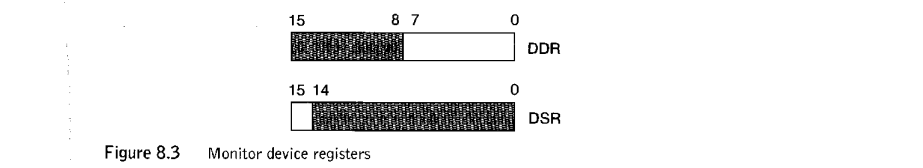

In the LC-3, DDR is assigned address xFE06. DSR is assigned address xFE04. 

### 8.3.2 The Basic Output Service Routine 
DSR[15] controls the synchronization of the fast processor and the slow monitor display

When the monitor finishes processing the character on the screen, it (the monitor) automatically sets DSR[15].
- This is a signal to the processor that it (the processor) can transfer another ASCII code to DDR for outputting.

If input/output is controlled by the processor (i.e., via polling), then a program can repeatedly test DSR[ 15] until it notes that the bit is set, indicating that it is OK to write a character to the screen. At that point, the processor can store the ASCII code for the character it wishes to write into DDR[7:0], setting up the transfer of that character to the monitor's display. 

## 8.4 A More Sophisticated Input Routine 
To let the person sitting at the keyboard know that the program is waiting for input from the keyboard, the computer typically prints a message on the monitor. Such a message is often referred to as a prompt. The symbol that is displayed by your operating system (for example, % or C:) or by your editor (for example,:) are examples of prompts.

Overall Process:
1. Save current values of registers to memory.
2. Write a newline and display the prompt to notify the user.
3. Poll for a keypress and read the input character from the keyboard buffer (KBDR).
4. Echo the character back to the monitor and write a final newline for clarity.
5. Restore saved register values and proceed with the next task in the program.
This routine exemplifies polling-based I/O, input prompting, and preserving system state during subroutine execution.

## 8.5 Interrupt-Driven I/O 
In Sections 8.2, 8.3, and 8.4, we have studied several examples of polling. In each case, the processor tested the Ready bit of the status register, again and again, and when it was finally 1, the processor branched to the instruction that did the input or output operation.

We are now ready to study the case where the interaction is controlled by the I/O device. 

### 8.5.1 What Is Interrupt-Driven 1/0?
The essence of interrupt-driven I/O is the notion that an I/O device that may or may not have anything to do with the program that is running can (1) force that program to stop, (2) have the processor carry out the needs of the I/O device, and then (3) have the stopped program resume execution as if nothing had happened. 

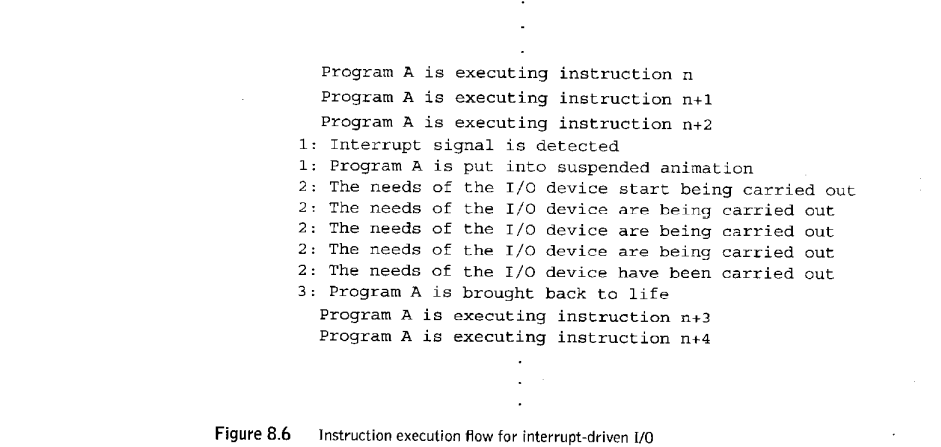

### 8.5.2 Why Have Interrupt-Driven I/O? 
polling requires the processor to waste a lot of time spinning its wheels, re-executing again and again the LDI and BR instructions until the Ready bit is set.

With interrupt-driven I/O, none of that testing and branching has to go on. Interrupt-driven I/O allows the processor to spend its time doing what is hopefully useful work, executing some other program perhaps, until it is notified that some I/O device needs attention.

**Interrupt-driven I/O is significantly more efficient, reducing the total task time because the processor can work on other tasks while waiting for input, instead of wasting time polling**.

### 8.5.3 Generation of the Interrupt Signal 
There are two parts to interrupt-driven I/O
1. the enabling mechanism that allows an I/O device to interrupt the processor when it has input to deliver or is ready to accept output
2. the mechanism that manages the transfer of the I/O data

**The two parts can be briefly described as:**
1. generating the interrupt signal, which stops the currently executing process
2. handling the request demanded by this signal

The first part we will study momentarily. We will examine the various things that must come together to force the processor to stop what it is doing and pay attention to the interrupt request

**Several things must be true for an I/O device to actually interrupt the processor:**
1. The I/O device must want service.
2. The device must have the right to request the service.
3. The device request must be more urgent than what the processor is currently doing

#### The Interrupt Signal from the Device 
For an I/O device to generate an interrupt request, the first two elements in the previous list must be true: The device must want service, and it must have the right to request that service.

In most I/O devices, this interrupt enable (IE) bit is part of the device status register. In the KBSR and DSR shown in Figure 8.7, the IE bit is bit [14]. 

#### The Importance of Priority 
Every instruction that the processor executes, it does with a stated level of urgency. The term we give for the urgency of execution is **priority**

We say that a program is being executed at a specified priority level. Almost all computers have a set of priority levels that programs can run at.

The LC-3 has eight priority levels, PLO,.. PL7. The higher the number, the more urgent the program.

For example, a computer's payroll program may run overnight, and at PLO. It has all night to finish—not terribly urgent. A program that corrects for a nuclear plant current surge may run at PL6. We are perfectly happy to let the payroll wait while the nuclear power correction keeps us from being blown to bits.

**Figure 8.8** shows the status registers of several devices operating at various priority levels. 
- Any device that has bits [14] and [15] both set asserts its interrupt request signal. 
- The interrupt request signals are input to a priority encoder, a combinational logic structure that selects the highest priority request from all those asserted. 
- If the PL of that request is higher than the PL of the currently executing program, the INT signal is asserted and the executing program is stopped. 

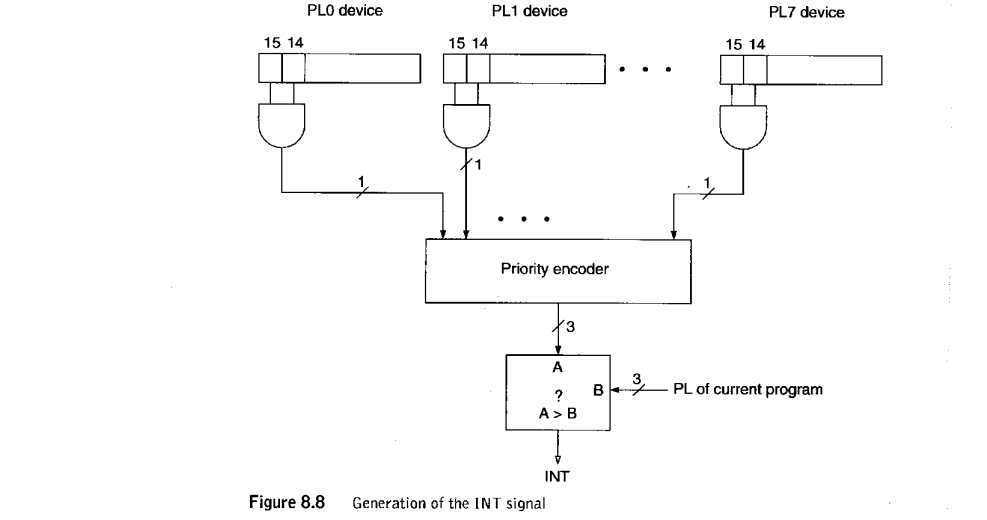

#### The Test for INT 
The final step in the first part of interrupt-driven I/O is the test to see if the processor should stop and handle an interrupt.

Recall the instruction cycle sequences through the six phases of FETCH, DECODE, EVALUATE ADDRESS, FETCH OPERAND, EXECUTE, and STORE RESULT. 

Recall further that after the sixth phase, the control unit returns to the first phase, that is, the FETCH of the next instruction. 

The additional logic to test for the interrupt signal is to replace that last sequential step of always going from STORE RESULT back to FETCH, as follows: The STORE RESULT phase is instead accompanied by a test for the interrupt signal INT.

If INT is not asserted, then it is business as usual, with the control unit returning to the FETCH phase to start processing the next instruction. If INT is asserted, then the control unit does two things before returning to the FETCH phase. First it saves enough state information to be able to return to the interrupted program where it left off. Second it loads the PC with the starting address of the program that is to carry out the requirements of the I/O device. 

## 8.6 Implementation of Memory-Mapped I/O, Revisited 
in order to support interrupt-driven I/O, the two status registers must be writeable as well as readable.

Figure 8.9 (reproduced from Figure C.3 of Appendix C) shows the data path necessary to support the full range of features we have discussed for the I/O device registers. 

The Address Control Logic block controls the input or output operation